<a href="https://colab.research.google.com/github/iCarrrot/nn_sudoku_project/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End of term project for Deep Learning course, SS 2020 @ University of Wrocław
Authors:
* Piotr Gdowski
* Michał Martusewicz


## Main goal
Extend the handwritten digit-recognizing network to allow verifying sudoku's solution correctness

# Befor start: runtime -> change runtime type -> GPU

In [1]:
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

from sklearn.neighbors import KNeighborsClassifier
import torch
import torchvision
from sklearn.decomposition import PCA


try:
    from src.net import *
    from src.preprocessing import *
    from src.util import *
    
except ModuleNotFoundError:
    import httpimport
    with httpimport.github_repo(
            'iCarrrot', 
            'nn_sudoku_project',
            module='src',
            branch='master'
    ):
        from src.net import *
        from src.preprocessing import *
        from src.util import *

Populating the interactive namespace from numpy and matplotlib


### TODO

* dzielenie datasetu
* downsampling obrazków
* metoda szybko printująca obrazek
* wycinanie diagramu z modyfikowanym thresholdem
* spięcie całości w metodę
* cięcie diagramu
* import sieci do rozpoznawania liczb
* konsumpcja outputu sieci

* solver: https://towardsdatascience.com/solving-sudoku-with-convolution-neural-network-keras-655ba4be3b11 
* solving krok po kroku: RNN?
* jakies ładne ogarnięcie całości

In [2]:
pics_path = get_pics_path()
gray_images, labels= get_gray_images(pics_path)
gray_images.shape

/home/michal/Studia/nn_sudoku_project/venv/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


(101, 4160, 3120)

# Dataset

100%|██████████| 101/101 [01:25<00:00,  1.18it/s]


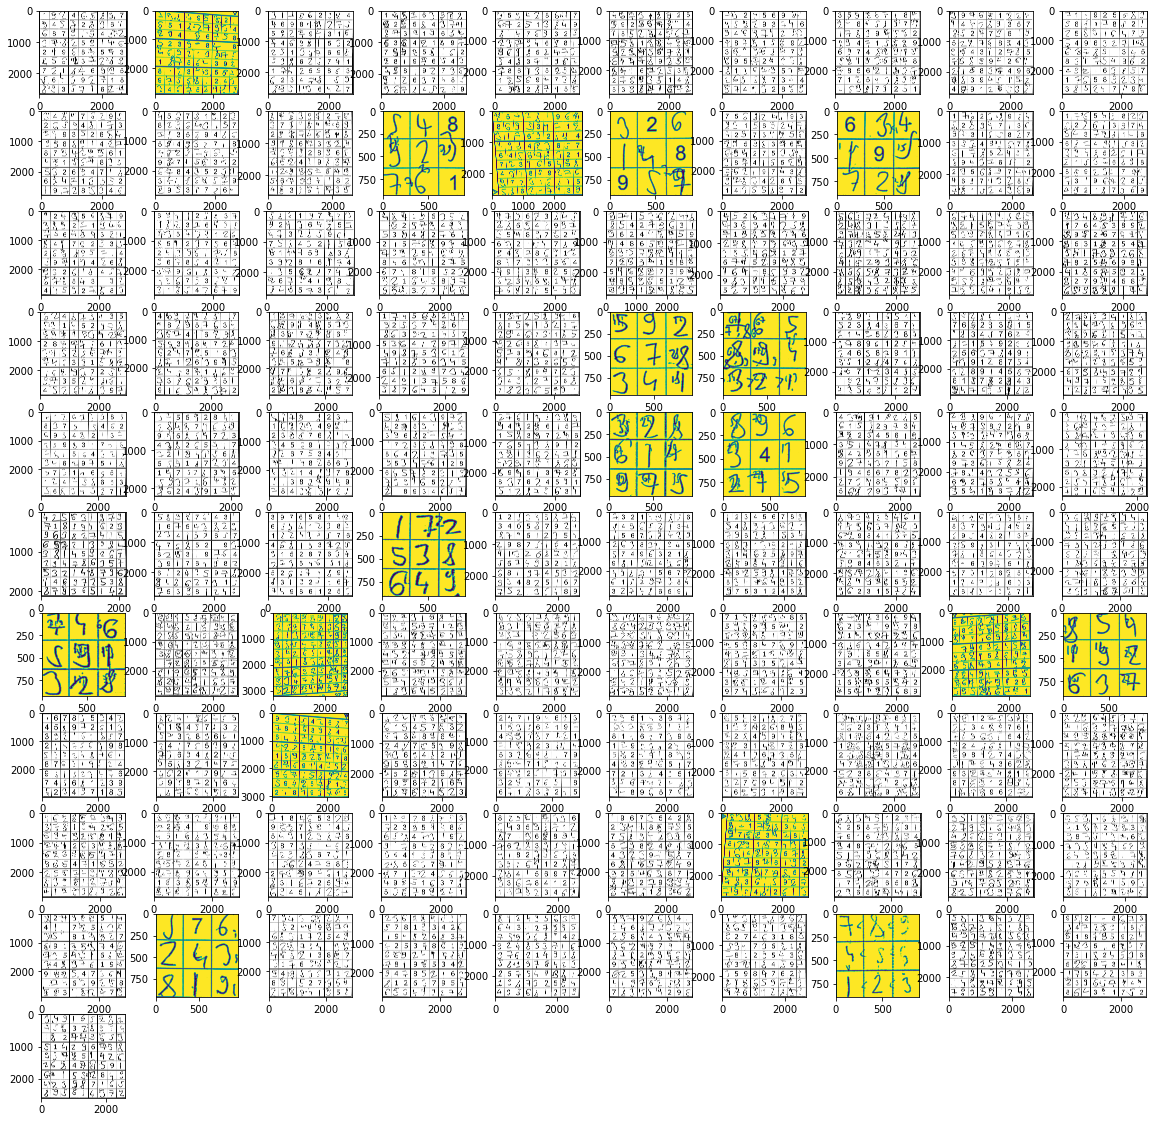

In [3]:
# from src.preprocessing import Deskewing,  split_into_cells, deskew_verify
ok_ids = [0, 22, 23, 25, 26, 33]
wrong_ids = [1]
deskewed_imgs = []
desk_img_labels = []
plt.figure(figsize=(20, 20))
for i in tqdm(range(len(gray_images))):
    deskewed = Deskewing(gray_images[i])._deskew()
    plt.subplot(11, 10, i + 1)
    if i not in ok_ids and (i in wrong_ids or not deskew_verify(deskewed)):
        plt.imshow(deskewed)
    else:
        plt.imshow(deskewed, cmap='gray')
        deskewed_imgs.append(deskewed)
        desk_img_labels.append(labels[i])

(6723, 28, 28)

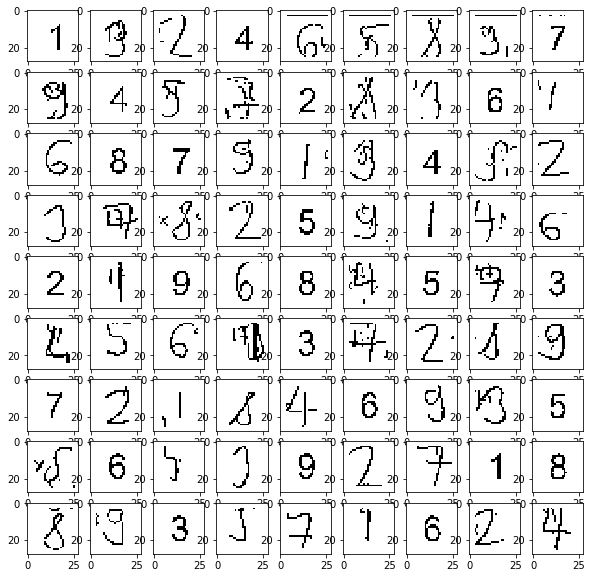

In [4]:
digits_labels = np.hstack(desk_img_labels)
digits = np.vstack([split_into_cells(x) for x in deskewed_imgs])
plt.figure(figsize=(10,10))
for i in range(81):
    plt.subplot(9, 9, i + 1)
    plt.imshow(digits[i, :, :], cmap='gray', interpolation='none')

np.savez('digits.npz',digits=digits, digits_labels=digits_labels)    
digits.shape

In [2]:
with open('digits.npz', 'rb') as f:
    npzfile = np.load(f)
    digits = npzfile['digits']
    digits_labels = npzfile['digits_labels']

In [3]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 81
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)


grid_test_loader, grid_train_loader = get_test_and_train_dataloader(digits, digits_labels, batch_size_test =batch_size_test, device='cuda')

In [5]:
# moved to util.py

## MNIST Dataset - sample digits and T-SNE decomposition

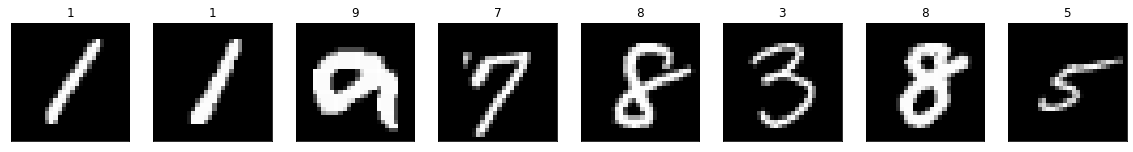

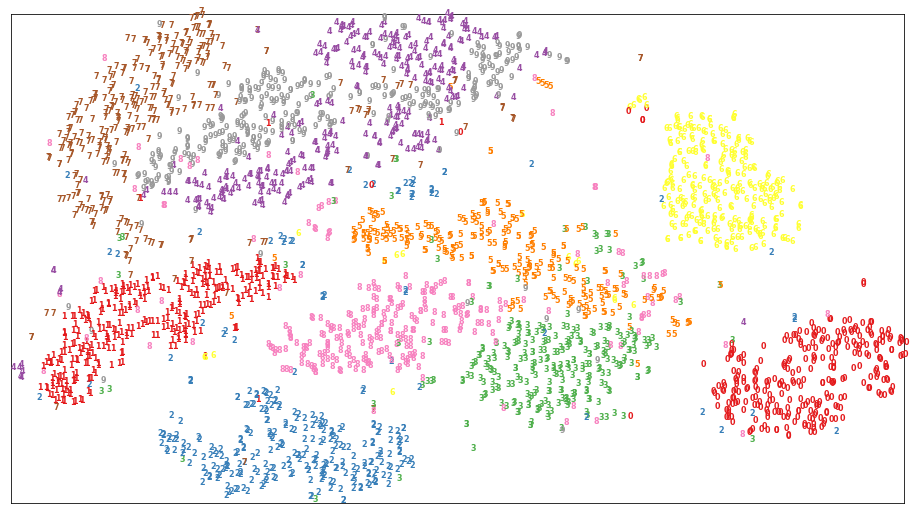

In [12]:
present_dataset(train_loader)

## Digits from sudoku grids - sample digits and T-SNE decomposition

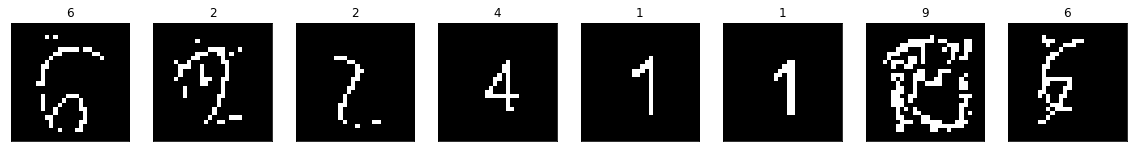

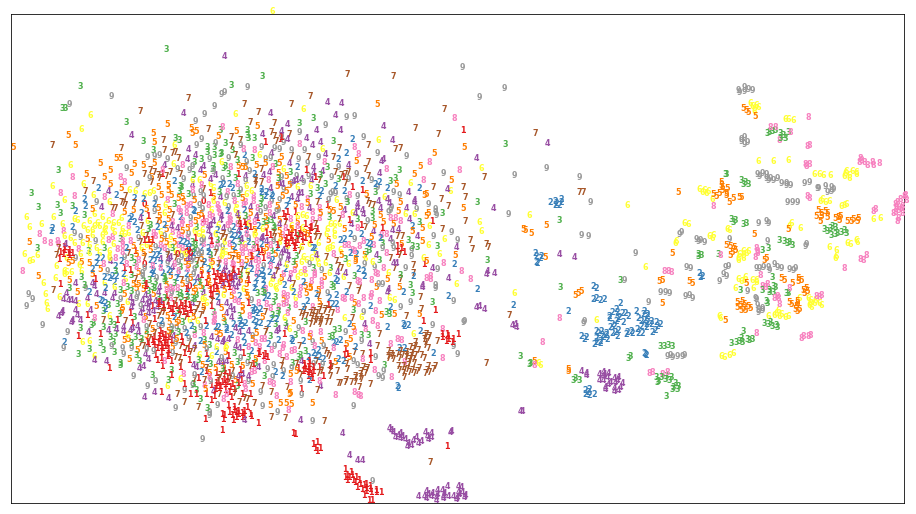

In [13]:
present_dataset(grid_train_loader)

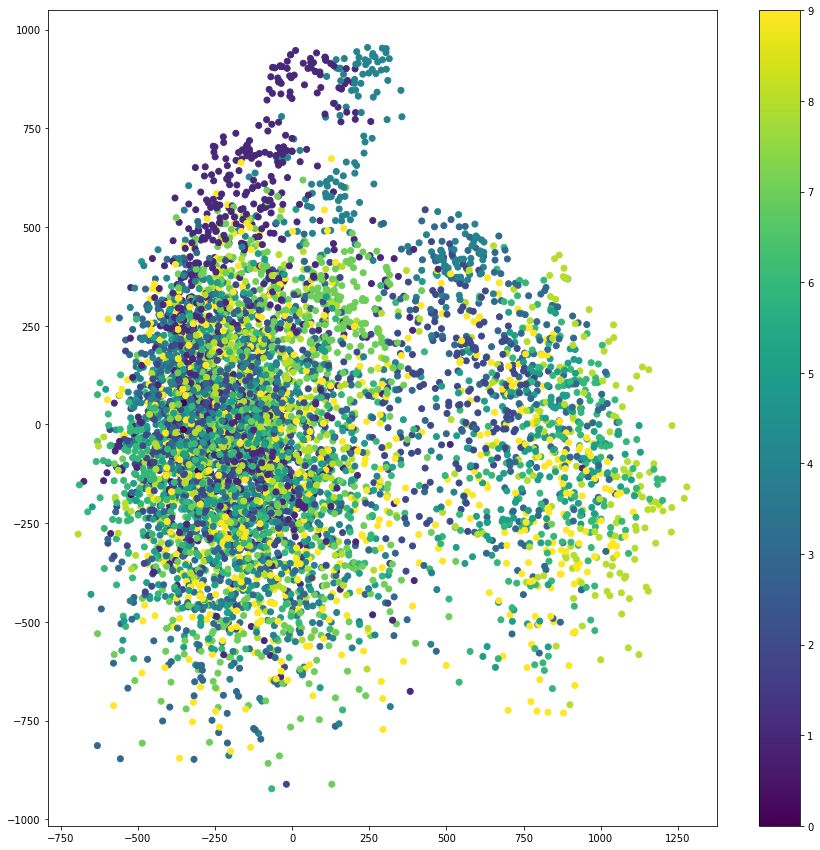

In [25]:
pca = PCA(n_components=2)
X = pca.fit_transform(digits.reshape(-1, 28*28))
X.shape
plt.figure(figsize=(15,15))
plt.scatter(X[:,0], X[:,1], c=digits_labels)
plt.colorbar()

# Classification

In this section we'll compare several approaches on classifying sudoku grids' digits.

## KNN

### 1: train on MNIST, test on sudoku_test

In [14]:
X, y = get_pure_data(train_loader)
clf = KNeighborsClassifier()
clf.fit(X, y)

X_test, y_test = get_pure_data(grid_test_loader)

clf.score(X_test, y_test)

0.248388696083292

### 2: train on sudoku_train, test on sudoku_test

In [32]:
X, y = get_pure_data(grid_train_loader)
clf = KNeighborsClassifier()
clf.fit(X, y)

X_test, y_test = get_pure_data(grid_test_loader)

clf.score(X_test, y_test)

0.46554288547347544

### 3: train on PCA(sudoku_train), test on PCA(sudoku_test)

In [39]:
X, y = get_pure_data(grid_train_loader)
X_test, y_test = get_pure_data(grid_test_loader)

for n_components in [10, 20, 30, 35, 40, 45, 50, 70, 100, 200]:
    pca = PCA(n_components=n_components)
    pca.fit(X)
    
    pca_train = pca.transform(X)
    pca_test = pca.transform(X_test)
    
    clf = KNeighborsClassifier()
    clf.fit(pca_train, y)

    print(f"{n_components} components: {clf.score(pca_test, y_test)}")


10 components: 0.6450173525037184
20 components: 0.7248388696083292
30 components: 0.7327714427367378
39 components: 0.7263262270699058
40 components: 0.7377293009419931
41 components: 0.7317798710956867
42 components: 0.7327714427367378
45 components: 0.7273177987109569
50 components: 0.7268220128904314
70 components: 0.7045116509667824
100 components: 0.6608824987605354
200 components: 0.5547843331680714


## NN

### Approach 1: Simple NN on different datasets

In [6]:
model = Net()
model.to('cuda')
train(model=model, device='cuda', train_loader=train_loader, title="Train on mnist dataset", optimizer=torch.optim.Adam(model.parameters()))
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train on mnist dataset
Train, Epoch: 1/1 [0/60000 (0%)]	Loss: 2.333409
Train, Epoch: 1/1 [6400/60000 (11%)]	Loss: 0.375385
Train, Epoch: 1/1 [12800/60000 (21%)]	Loss: 0.244579
Train, Epoch: 1/1 [19200/60000 (32%)]	Loss: 0.230099
Train, Epoch: 1/1 [25600/60000 (43%)]	Loss: 0.170432
Train, Epoch: 1/1 [32000/60000 (53%)]	Loss: 0.105326
Train, Epoch: 1/1 [38400/60000 (64%)]	Loss: 0.139883
Train, Epoch: 1/1 [44800/60000 (75%)]	Loss: 0.048110
Train, Epoch: 1/1 [51200/60000 (85%)]	Loss: 0.151610
Train, Epoch: 1/1 [57600/60000 (96%)]	Loss: 0.077560

Test set: Average loss: 115.1714, Accuracy: 1110/2017 (55%)



In [7]:
model = Net()
model.to('cuda')
train(model=model, device='cuda', train_loader=grid_train_loader, epoch=30, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()))
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train on own dataset
Train, Epoch: 1/30 [0/4698 (0%)]	Loss: 9.949532
Train, Epoch: 2/30 [0/4698 (0%)]	Loss: 1.660212
Train, Epoch: 3/30 [0/4698 (0%)]	Loss: 1.039312
Train, Epoch: 4/30 [0/4698 (0%)]	Loss: 0.730915
Train, Epoch: 5/30 [0/4698 (0%)]	Loss: 0.522658
Train, Epoch: 6/30 [0/4698 (0%)]	Loss: 0.463737
Train, Epoch: 7/30 [0/4698 (0%)]	Loss: 0.310473
Train, Epoch: 8/30 [0/4698 (0%)]	Loss: 0.413083
Train, Epoch: 9/30 [0/4698 (0%)]	Loss: 0.262086
Train, Epoch: 10/30 [0/4698 (0%)]	Loss: 0.213323
Train, Epoch: 11/30 [0/4698 (0%)]	Loss: 0.147225
Train, Epoch: 12/30 [0/4698 (0%)]	Loss: 0.197304
Train, Epoch: 13/30 [0/4698 (0%)]	Loss: 0.119570
Train, Epoch: 14/30 [0/4698 (0%)]	Loss: 0.391461
Train, Epoch: 15/30 [0/4698 (0%)]	Loss: 0.237976
Train, Epoch: 16/30 [0/4698 (0%)]	Loss: 0.119249
Train, Epoch: 17/30 [0/4698 (0%)]	Loss: 0.145115
Train, Epoch: 18/30 [0/4698 (0%)]	Loss: 0.138910
Train, Epoch: 19/30 [0/4698 (0%)]	Loss: 0.244024
Train, Epoch: 20/30 [0/4698 (0%)]	Loss: 0.143466
Train, E

### Approach 2: Simple ExperimentalNet NN on different datasets

# Test section

### Example NN
[PyTorch MNIST](https://github.com/pytorch/examples/blob/master/mnist/main.py)

In [8]:
model = ExperimentalNet()
model.to('cuda')
train(model=model, device='cuda', train_loader=grid_train_loader, epoch=100, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()))
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train on own dataset
Train, Epoch: 1/100 [0/4698 (0%)]	Loss: 5.829572
Train, Epoch: 2/100 [0/4698 (0%)]	Loss: 0.999899
Train, Epoch: 3/100 [0/4698 (0%)]	Loss: 0.636667
Train, Epoch: 4/100 [0/4698 (0%)]	Loss: 0.410869
Train, Epoch: 5/100 [0/4698 (0%)]	Loss: 0.279477
Train, Epoch: 6/100 [0/4698 (0%)]	Loss: 0.250025
Train, Epoch: 7/100 [0/4698 (0%)]	Loss: 0.307024
Train, Epoch: 8/100 [0/4698 (0%)]	Loss: 0.240916
Train, Epoch: 9/100 [0/4698 (0%)]	Loss: 0.198774
Train, Epoch: 10/100 [0/4698 (0%)]	Loss: 0.169739
Train, Epoch: 11/100 [0/4698 (0%)]	Loss: 0.173640
Train, Epoch: 12/100 [0/4698 (0%)]	Loss: 0.192510
Train, Epoch: 13/100 [0/4698 (0%)]	Loss: 0.277269
Train, Epoch: 14/100 [0/4698 (0%)]	Loss: 0.147621
Train, Epoch: 15/100 [0/4698 (0%)]	Loss: 0.156198
Train, Epoch: 16/100 [0/4698 (0%)]	Loss: 0.077473
Train, Epoch: 17/100 [0/4698 (0%)]	Loss: 0.061949
Train, Epoch: 18/100 [0/4698 (0%)]	Loss: 0.057848
Train, Epoch: 19/100 [0/4698 (0%)]	Loss: 0.177541
Train, Epoch: 20/100 [0/4698 (0%)]	Los

In [10]:
model = ExperimentalNet()
model.to('cuda')
train(model=model, device='cuda', train_loader=grid_train_loader, epoch=500, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()), test_loader=grid_test_loader)
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train on own dataset
Train, Epoch: 1/500 [0/4698 (0%)]	Loss: 5.096944

Test set: Average loss: 0.6936, Accuracy: 1638/2025 (81%)

Train, Epoch: 2/500 [0/4698 (0%)]	Loss: 0.520381

Test set: Average loss: 0.4624, Accuracy: 1758/2025 (87%)

Train, Epoch: 3/500 [0/4698 (0%)]	Loss: 0.168707

Test set: Average loss: 0.5391, Accuracy: 1758/2025 (87%)

Train, Epoch: 4/500 [0/4698 (0%)]	Loss: 0.058612

Test set: Average loss: 0.5469, Accuracy: 1771/2025 (87%)

Train, Epoch: 5/500 [0/4698 (0%)]	Loss: 0.025919

Test set: Average loss: 0.6356, Accuracy: 1722/2025 (85%)

Train, Epoch: 6/500 [0/4698 (0%)]	Loss: 0.041990

Test set: Average loss: 0.7238, Accuracy: 1769/2025 (87%)

Train, Epoch: 7/500 [0/4698 (0%)]	Loss: 0.010150

Test set: Average loss: 0.7090, Accuracy: 1786/2025 (88%)

Train, Epoch: 8/500 [0/4698 (0%)]	Loss: 0.050786

Test set: Average loss: 0.7090, Accuracy: 1793/2025 (89%)

Train, Epoch: 9/500 [0/4698 (0%)]	Loss: 0.002762

Test set: Average loss: 0.7685, Accuracy: 1785/2025 (88%)


Test set: Average loss: 0.9434, Accuracy: 1811/2025 (89%)

Train, Epoch: 76/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 0.9456, Accuracy: 1811/2025 (89%)

Train, Epoch: 77/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 0.9480, Accuracy: 1811/2025 (89%)

Train, Epoch: 78/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 0.9504, Accuracy: 1812/2025 (89%)

Train, Epoch: 79/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 0.9526, Accuracy: 1812/2025 (89%)

Train, Epoch: 80/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 0.9548, Accuracy: 1812/2025 (89%)

Train, Epoch: 81/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 0.9571, Accuracy: 1812/2025 (89%)

Train, Epoch: 82/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 0.9594, Accuracy: 1812/2025 (89%)

Train, Epoch: 83/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 0.9616, Accuracy: 1812/2025 (89%)

Train, Epoch: 84/500 [0/4698 (0%)]	Loss: 0.000001

Test set:


Test set: Average loss: 1.0661, Accuracy: 1815/2025 (90%)

Train, Epoch: 151/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0667, Accuracy: 1815/2025 (90%)

Train, Epoch: 152/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0675, Accuracy: 1815/2025 (90%)

Train, Epoch: 153/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0681, Accuracy: 1815/2025 (90%)

Train, Epoch: 154/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0686, Accuracy: 1815/2025 (90%)

Train, Epoch: 155/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0692, Accuracy: 1814/2025 (90%)

Train, Epoch: 156/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0697, Accuracy: 1813/2025 (90%)

Train, Epoch: 157/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0701, Accuracy: 1813/2025 (90%)

Train, Epoch: 158/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0705, Accuracy: 1813/2025 (90%)

Train, Epoch: 159/500 [0/4698 (0%)]	Loss: 0.000000




Test set: Average loss: 1.0375, Accuracy: 1810/2025 (89%)

Train, Epoch: 225/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0368, Accuracy: 1810/2025 (89%)

Train, Epoch: 226/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0367, Accuracy: 1811/2025 (89%)

Train, Epoch: 227/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0364, Accuracy: 1810/2025 (89%)

Train, Epoch: 228/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0364, Accuracy: 1809/2025 (89%)

Train, Epoch: 229/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0357, Accuracy: 1811/2025 (89%)

Train, Epoch: 230/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0356, Accuracy: 1811/2025 (89%)

Train, Epoch: 231/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0353, Accuracy: 1811/2025 (89%)

Train, Epoch: 232/500 [0/4698 (0%)]	Loss: 0.000000

Test set: Average loss: 1.0359, Accuracy: 1811/2025 (89%)

Train, Epoch: 233/500 [0/4698 (0%)]	Loss: 0.000000




Test set: Average loss: 0.9988, Accuracy: 1777/2025 (88%)

Train, Epoch: 299/500 [0/4698 (0%)]	Loss: 0.000024

Test set: Average loss: 1.0033, Accuracy: 1778/2025 (88%)

Train, Epoch: 300/500 [0/4698 (0%)]	Loss: 0.000022

Test set: Average loss: 1.0077, Accuracy: 1779/2025 (88%)

Train, Epoch: 301/500 [0/4698 (0%)]	Loss: 0.000021

Test set: Average loss: 1.0123, Accuracy: 1779/2025 (88%)

Train, Epoch: 302/500 [0/4698 (0%)]	Loss: 0.000020

Test set: Average loss: 1.0166, Accuracy: 1779/2025 (88%)

Train, Epoch: 303/500 [0/4698 (0%)]	Loss: 0.000019

Test set: Average loss: 1.0211, Accuracy: 1781/2025 (88%)

Train, Epoch: 304/500 [0/4698 (0%)]	Loss: 0.000017

Test set: Average loss: 1.0254, Accuracy: 1781/2025 (88%)

Train, Epoch: 305/500 [0/4698 (0%)]	Loss: 0.000017

Test set: Average loss: 1.0295, Accuracy: 1781/2025 (88%)

Train, Epoch: 306/500 [0/4698 (0%)]	Loss: 0.000016

Test set: Average loss: 1.0334, Accuracy: 1781/2025 (88%)

Train, Epoch: 307/500 [0/4698 (0%)]	Loss: 0.000015




Test set: Average loss: 1.2265, Accuracy: 1781/2025 (88%)

Train, Epoch: 373/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 1.2288, Accuracy: 1780/2025 (88%)

Train, Epoch: 374/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 1.2316, Accuracy: 1781/2025 (88%)

Train, Epoch: 375/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 1.2342, Accuracy: 1781/2025 (88%)

Train, Epoch: 376/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 1.2367, Accuracy: 1781/2025 (88%)

Train, Epoch: 377/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 1.2386, Accuracy: 1781/2025 (88%)

Train, Epoch: 378/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 1.2412, Accuracy: 1781/2025 (88%)

Train, Epoch: 379/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 1.2443, Accuracy: 1781/2025 (88%)

Train, Epoch: 380/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 1.2470, Accuracy: 1782/2025 (88%)

Train, Epoch: 381/500 [0/4698 (0%)]	Loss: 0.000001




Test set: Average loss: 1.4393, Accuracy: 1781/2025 (88%)

Train, Epoch: 447/500 [0/4698 (0%)]	Loss: 0.000001

Test set: Average loss: 1.5494, Accuracy: 1550/2025 (77%)

Train, Epoch: 448/500 [0/4698 (0%)]	Loss: 0.376980

Test set: Average loss: 0.8040, Accuracy: 1744/2025 (86%)

Train, Epoch: 449/500 [0/4698 (0%)]	Loss: 0.109075

Test set: Average loss: 0.8682, Accuracy: 1738/2025 (86%)

Train, Epoch: 450/500 [0/4698 (0%)]	Loss: 0.000652

Test set: Average loss: 0.8781, Accuracy: 1764/2025 (87%)

Train, Epoch: 451/500 [0/4698 (0%)]	Loss: 0.000335

Test set: Average loss: 0.9019, Accuracy: 1776/2025 (88%)

Train, Epoch: 452/500 [0/4698 (0%)]	Loss: 0.000169

Test set: Average loss: 0.9461, Accuracy: 1777/2025 (88%)

Train, Epoch: 453/500 [0/4698 (0%)]	Loss: 0.000082

Test set: Average loss: 0.9816, Accuracy: 1774/2025 (88%)

Train, Epoch: 454/500 [0/4698 (0%)]	Loss: 0.000026

Test set: Average loss: 1.0841, Accuracy: 1766/2025 (87%)

Train, Epoch: 455/500 [0/4698 (0%)]	Loss: 0.000005

